In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append(r"C:\Users\passenh\Documents\Harris\yr2_q1\ml\project\InterpretableDimRed")

In [3]:
import numpy as np 
import numpy.linalg as la
from InterpretableDimRed.utils import pca_svd_utils as psa
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
#Update the data directory to reflect your local machine
data_directory = "C:\\Users\\passenh\\Documents\\Harris\\yr2_q1\\ml\\project\\InterpretableDimRed\\InterpretableDimRed\\RawData\\"

# Building Interpretable Directions (Gu and Chipman)
Predict if patients will have heart disease or not based on 13 features.
For more info on this dataset see: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Chipman and Gu suggest taking the correlation between principle components and the original features, and applying a sort of thresholding algorithm to reset the coefficients in a way that may make them more interpretable. Among all the PC directions,

##### For k = 1, 2, ... p, identify the k non-zero elements of the PC direction vector. 
- Take the k elements with the largest absolute value, and set it equal to +1/-1 / sqrt(k); 
- set all other elements equal to zero;  

##### Then find the vector with k elements which is "closest" to the original PC direction vector, and this is the "interpretable" direction. 

While Chipman and Gu measure angles between vectors, I am using the squared distance between the vectors as a measure of closeness.     

Their preprocessing includes removing categorical variables.

### Preprocessing

In [4]:
heart_data = pd.read_csv(data_directory + "heartDisease.csv")
heart_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
#remove categorical data
cont_vars = ["age", "trestbps", "chol", "thalach", "oldpeak"]

heart_cont = heart_data[cont_vars + ["target"]]
heart_cont.head()

,age,trestbps,chol,thalach,oldpeak,target
0,63,145,233,150,2.3,1
1,37,130,250,187,3.5,1
2,41,130,204,172,1.4,1
3,56,120,236,178,0.8,1
4,57,120,354,163,0.6,1


In [6]:
#normalize
heart_norm = psa.normalize(heart_cont, cont_vars)
heart_norm.head()

,age,trestbps,chol,thalach,oldpeak,target
0,0.952197,0.763956,-0.256334,0.015443,1.087338,1
1,-1.915313,-0.092738,0.072199,1.633471,2.122573,1
2,-1.474158,-0.092738,-0.816773,0.977514,0.310912,1
3,0.180175,-0.663867,-0.198357,1.239897,-0.206705,1
4,0.290464,-0.663867,2.082050,0.583939,-0.379244,1


In [7]:
#separate the X and Y matrices
X = heart_norm.iloc[:,:-1]
Y = heart_norm.loc[:,"target"]

#set all the zeros to negative one
Y[Y == 0] = -1

C:\Users\passenh\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Get principle components, and see correlations. 

In [8]:
pca = PCA(n_components=5, svd_solver='full')
pca.fit(X.T)

components = pca.components_

In [9]:
psa.corr_pc_features(X, components)

,PC1,PC2,PC3,PC4,PC5
age,-0.668345,0.318651,-0.361172,0.377165,0.01806
trestbps,-0.246095,-0.270005,-0.626999,-0.542521,0.01806
chol,-0.048788,0.757139,0.181113,-0.460957,0.01806
thalach,0.890973,-0.116014,-0.035809,0.111126,0.01806
oldpeak,-0.602736,-0.414141,0.515593,-0.142420,0.01806


In absolute magnitude terms the highest correlated variable is "thalach", which corresponds to the maximum heart rate of the patient, with age as the next most correlated variable, followed by oldpeak. 

### Run Chipman and Gu's algorithm 

Now, using Chipman and Gu's algorithm, we can try to find more "interpretable" directions for each principle component direction, and see the correlation between the intepretable directions and the original features.

In [10]:
#set up a matrix for the new interpretable directions
interp = np.zeros(components.shape)

for i, row in enumerate(components):
    pcrow = psa.c_and_g_algo(row)
    interp[i] = pcrow

In [11]:
psa.corr_pc_features(X, interp)

,PC1,PC2,PC3,PC4,PC5
age,-0.631758,0.286599,-0.325501,0.332937,-0.005173
trestbps,-0.236874,-0.251287,-0.565993,-0.455793,-0.006697
chol,-0.033860,0.636719,0.183764,-0.438569,0.079771
thalach,0.799845,-0.121023,-0.022245,0.129364,-0.009231
oldpeak,-0.559067,-0.365813,0.420799,-0.127505,0.121398


There is very little difference between the correlation of the interpretable direction and the original features - in the first "interpretable component" direction, the same variables have the highest correlation with the new interpretable directions. Age and oldpeak appear to be closer together, in absolute magnitude terms. 


### Use the most important principle components to make a classification prediction

Now, we can compare least squares classification, normal PCA, and Chipman and Gu's "interpretable directions" and examine performance. For consistency and valid comparisons, we we use least squares classification on the original features, the reduced dimension PCA and and reduced dimension Interpretable Directions.

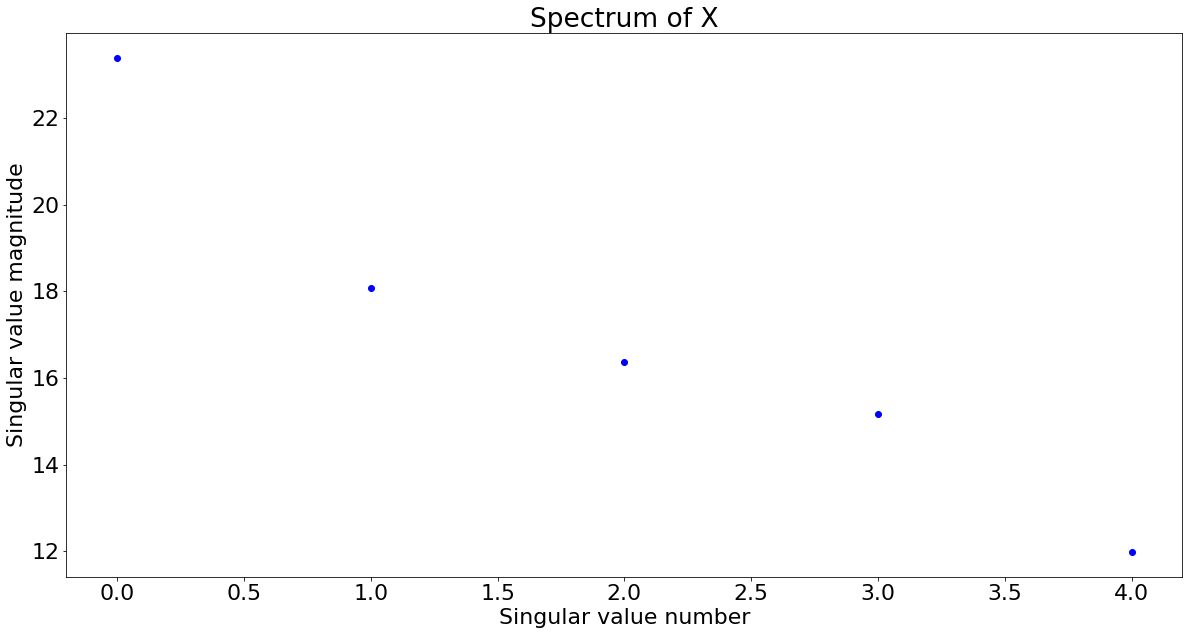

In [12]:
# Identify the most important principle components 
psa.plot_spectrum(X.T)

The first principle component looks like it has a greater difference from the next PC than all the others are from each other. I will therefore only consider the first principle component, and the corresponding interpretable component direction

In [13]:
#Get the first PCA direction and the first interpretable component direction
pca1 = components[0]
interp1 = interp[0]

pca1 = pca1.reshape(1, len(pca1))
interp1 = interp1.reshape(1, len(interp1))

In [14]:
X_train, X_test, y_train, y_test = psa.train_test_split_w(X, Y)
y_predicted = psa.least_squares_classifier(X_train.values, X_test.values, y_train.values)
print("""Accuracy score on the test set for a LS classifier using the original feature space is: {}""".format(accuracy_score(y_test.values, y_predicted)))

X_train_pca, X_test_pca, y_train_pca, y_test_pca = psa.train_test_split_w(pca1.T, Y)
y_predicted_pca = psa.least_squares_classifier(X_train_pca, X_test_pca, y_train_pca)
print("""Accuracy score on the test set for a LS classifier using principal component vector space is {}""".format(accuracy_score(y_test_pca.values, y_predicted_pca)))

X_train_interp, X_test_interp, y_train_interp, y_test_interp = psa.train_test_split_w(interp1.T, Y)
y_predicted_interp = psa.least_squares_classifier(X_train_interp, X_test_interp, y_train_interp.values)
print("""Accuracy score on the test set for a LS classifier using interpretable directions vector space is {}""".format(accuracy_score(y_test_interp.values, y_predicted_interp)))

Accuracy score on the test set for a LS classifier using the original feature space is: 0.7213114754098361
Accuracy score on the test set for a LS classifier using principal component vector space is 0.7049180327868853
Accuracy score on the test set for a LS classifier using interpretable directions vector space is 0.4098360655737705


The dimensionality-reduced Chipman and Gu "interpretable" directions results in significantly lower classification accuracy - the normal PCA dimensionality-reduced feature space performs much better than the more intepretable directions. 


## Repeat with another dataset

Predict if NBA rookies will last 5 or more years in the NBA based on player sats.

For more info on dataset visit: https://data.world/exercises/logistic-regression-exercise-1

### Step 1: Load and preprocess data

In [15]:
# Load and preprocess data
nba = pd.read_csv(data_directory + "nba_logreg.csv")
nba.head()  

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


In [16]:
#remove categorical data and normalize
nba = nba.loc[:, "GP":"TARGET_5Yrs"]
nba_cont = nba.columns[:-1]

#normalize
nba_norm = psa.normalize(nba, nba_cont)

#drop NA
nba_norm = nba_norm.dropna()
nba_norm.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,-1.400901,1.177066,0.137401,-0.017294,0.477347,-1.543407,0.658041,1.244354,0.355367,0.306333,0.361484,-0.037855,-0.398290,1.010852,0.517997,0.237640,-0.533458,0.073254,0.147338,0.0
1,-1.458281,1.116860,0.091486,-0.373816,0.226801,-2.374651,1.179494,1.903829,0.261716,1.319630,1.193248,0.586286,-0.655746,-0.018938,-0.308447,1.461613,1.175502,0.306415,0.562695,0.0
2,0.779563,-0.279912,-0.367659,-0.373816,-0.329969,-0.320991,0.397315,0.867511,0.317907,-0.402975,-0.394665,-0.312099,-0.655746,-0.239607,-0.405676,-0.374347,-0.289321,-0.159906,-0.268019,0.0
3,-0.138527,-0.725434,-0.252873,-0.195555,-0.107261,-0.255795,-0.384863,-0.263016,0.205525,-0.402975,-0.394665,-0.132422,-0.012104,-0.828059,-0.551519,-0.510344,-0.045184,-0.626228,-0.268019,1.0
4,-0.712333,-0.737475,-0.528360,-0.611497,-0.803224,1.341496,-0.645589,-0.639859,-1.205486,0.002344,0.059025,-0.274272,-0.012104,-0.386720,-0.259833,-0.850337,-0.777595,0.073254,-0.544923,1.0


In [17]:
#separate the X and Y matrices
nba_X = nba_norm.iloc[:,:-1]
nba_Y = nba_norm.loc[:, "TARGET_5Yrs"]

#set all the zeros to negative one
nba_Y[nba_Y == 0] = -1

### Step 2: Get principle components direction and see correlations

In [18]:
nba_pca = PCA(n_components=len(nba_cont), svd_solver='full')
nba_pca.fit(nba_X.T)

nba_components = nba_pca.components_

In [19]:
psa.corr_pc_features(nba_X, nba_components)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
GP,-0.236029,-0.343019,0.237616,-0.136524,-0.265339,0.676489,0.224289,0.130319,-0.049277,0.059889,-0.158643,0.005532,0.086379,0.114911,-0.087291,-0.131122,0.229281,-0.068767,-0.006498
MIN,-0.206750,-0.687284,-0.255304,0.010535,-0.068198,0.250106,0.011722,-0.157500,-0.193449,0.063170,-0.276159,-0.069609,0.300408,0.107211,-0.082473,-0.131551,0.228391,-0.068658,-0.006697
PTS,-0.246465,-0.724943,-0.248196,0.186795,0.147330,0.239152,0.099463,-0.033678,-0.218237,0.066556,-0.156979,-0.011156,0.073256,0.144713,-0.102589,-0.159885,0.244975,-0.076305,-0.006783
FGM,-0.288764,-0.708846,-0.226842,0.151880,0.141458,0.246813,0.114275,-0.077909,-0.311493,0.057099,-0.120655,-0.005971,0.052195,0.131797,-0.083008,-0.160242,0.214153,-0.062773,-0.006731
FGA,-0.153008,-0.763221,-0.278769,0.165700,0.076958,0.253153,0.098692,-0.070133,-0.298539,0.059366,-0.097583,-0.008859,0.056442,0.078110,-0.074756,-0.077049,0.232695,-0.069127,-0.006814
FG%,-0.635172,0.153599,0.253563,-0.183581,0.503066,0.128771,0.011396,-0.086237,-0.147797,0.028786,-0.212560,0.023541,0.116573,0.106399,-0.087867,-0.126220,0.231222,-0.069223,-0.006093
3P Made,0.655209,-0.190411,-0.488216,-0.042110,0.118767,0.306792,-0.114495,-0.017908,-0.017357,0.040421,-0.152510,0.019344,0.106962,0.196818,-0.072999,-0.112430,0.228125,-0.068237,-0.006839
3PA,0.669269,-0.245169,-0.491150,-0.030285,0.083193,0.287145,-0.129674,-0.017506,-0.015137,0.049009,-0.138386,0.016748,0.086423,0.033628,-0.100975,-0.151059,0.229467,-0.068732,-0.006884
3P%,0.649360,-0.031501,-0.201580,0.075329,-0.076790,-0.101251,0.569552,-0.051909,-0.144645,0.023698,-0.186182,0.008221,0.116061,0.114311,-0.087923,-0.131564,0.230081,-0.068967,-0.006554
FTM,-0.353590,-0.707066,-0.130173,0.320825,0.123890,0.094605,0.092172,0.123761,0.107836,0.082127,-0.223701,-0.038213,0.105263,0.122904,-0.143780,-0.114003,0.224949,-0.066973,-0.006831


At at glance, it appears that the number of offensive rebounds and total rebounds have the highest correlation in absolute magnitude, followed by blocks and 3 points made. 

### Run Chipman and Gu's algorithm to see the "interpretable" principle component directions. 

Again, using Chipman and Gu's algorithm, we can try to find more "interpretable" directions for each principle component direction, and see the correlation between the intepretable directions and the original features.

In [20]:
#set up a matrix for the new interpretable directions
nba_interp = np.zeros(nba_components.shape)

for i, row in enumerate(nba_components):
    pcrow = psa.c_and_g_algo(row)
    nba_interp[i] = pcrow

In [21]:
psa.corr_pc_features(nba_X, nba_interp)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
GP,-0.215894,-0.321136,0.210271,-0.117921,-0.234511,0.651689,0.242217,0.153270,-0.035338,0.068751,-0.145941,0.016437,0.121243,0.090105,-0.114466,-0.101524,0.208746,-0.033750,-0.025597
MIN,-0.147460,-0.587190,-0.246433,0.011990,-0.032139,0.247760,0.038423,-0.135459,-0.176537,0.053240,-0.263682,-0.066964,0.339475,0.086317,-0.081283,-0.112637,0.199889,-0.030389,-0.020067
PTS,-0.174928,-0.602951,-0.229447,0.161796,0.153812,0.229024,0.111130,-0.030472,-0.180210,0.059449,-0.142733,-0.016222,0.149636,0.117533,-0.083722,-0.111428,0.223177,-0.020778,-0.002434
FGM,-0.215482,-0.592882,-0.211430,0.133215,0.149776,0.234746,0.123387,-0.069586,-0.259235,0.050958,-0.112397,-0.011902,0.131242,0.108283,-0.074847,-0.108681,0.194597,-0.014738,-0.008360
FGA,-0.095988,-0.647738,-0.255609,0.149463,0.092765,0.232555,0.116271,-0.060754,-0.253724,0.051759,-0.089090,-0.010081,0.129988,0.060724,-0.064171,-0.055838,0.209207,-0.018026,-0.006579
FG%,-0.618781,0.194155,0.221094,-0.182651,0.442944,0.166137,-0.038163,-0.080123,-0.119587,0.036750,-0.227823,0.003187,0.125480,0.075259,-0.125500,-0.059185,0.201856,-0.032243,0.005864
3P Made,0.605911,-0.156435,-0.421563,-0.046311,0.131038,0.221911,-0.075904,-0.012754,-0.042466,0.043855,-0.152432,0.019440,0.095592,0.111647,-0.059770,-0.159845,0.212336,-0.052034,0.007612
3PA,0.623733,-0.204968,-0.419742,-0.034268,0.098373,0.205014,-0.082936,-0.009991,-0.040457,0.047519,-0.139351,0.018903,0.075187,-0.023808,-0.083740,-0.202768,0.211226,-0.050270,0.006045
3P%,0.651905,-0.016431,-0.174584,0.070303,-0.061727,-0.116107,0.492742,-0.034931,-0.140838,0.035594,-0.191833,0.021179,0.141842,0.098742,-0.062874,-0.162535,0.202512,-0.057997,-0.026274
FTM,-0.270157,-0.575893,-0.126939,0.276661,0.119151,0.123829,0.098244,0.108729,0.105976,0.070826,-0.189372,-0.040243,0.176254,0.115174,-0.091975,-0.056797,0.202672,-0.012758,0.012220


In this instance, some of the correlations have shifted. While offensive rebounds is still the most highly correlated, the 3 pointers made and three point percentage are more highly correlated - suggesting that this direction is the "offensive shots" direction. Indeed, some of the next most highly correlated features are three point attempts, field goal percent, and total rebounds. This direction, in which offensive behavior is all highly correlated, does appear to be more interpretable than the original PCA direction vector. 

### Step 3: Use the most important principle components to make a classification prediction

Now, we can compare least squares classification, normal PCA, and Chipman and Gu's "interpretable directions" and examine performance. For consistency and valid comparisons, we we use least squares classification on the original features, the reduced dimension PCA and and reduced dimension Interpretable Directions.

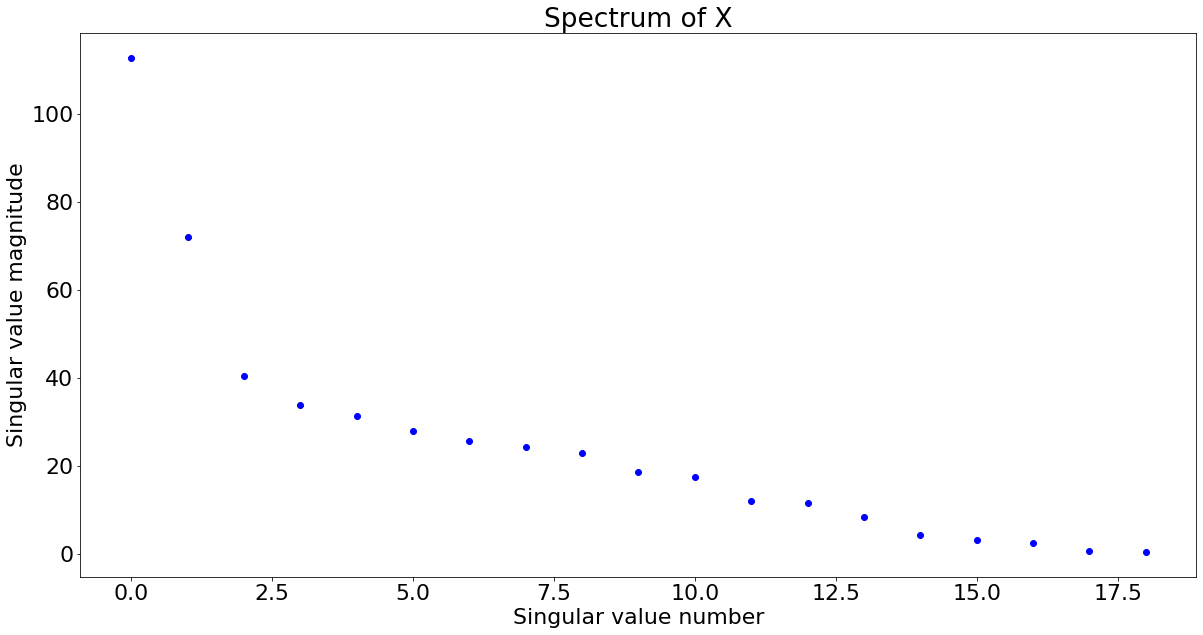

In [22]:
# Identify the most important principle components 
psa.plot_spectrum(nba_X.T)

The first two principle components appear to be largest, compared to the others - I will therefore reduce the data to 2 dimension both in the first two principle component directions, and in the "interpretable component" directions. 

In [23]:
#Get the first PCA direction and the first interpretable component direction
nba_pca2 = nba_components[:2]
nba_interp2 = nba_interp[:2]

In [24]:
nba_X_train, nba_X_test, nba_y_train, nba_y_test = psa.train_test_split_w(nba_X, nba_Y)
nba_y_predicted = psa.least_squares_classifier(nba_X_train.values, nba_X_test.values, nba_y_train.values)
print("""Accuracy score on the test set for a LS classifier using 
         the original feature space is: {}""".format(accuracy_score(nba_y_test.values, nba_y_predicted)))

nba_X_train_pca, nba_X_test_pca, nba_y_train_pca, nba_y_test_pca = psa.train_test_split_w(nba_pca2.T, nba_Y)
nba_y_predicted_pca = psa.least_squares_classifier(nba_X_train_pca, nba_X_test_pca, nba_y_train_pca)
print("""Accuracy score on the test set for a LS classifier using 
         principal component vector space is {}""".format(accuracy_score(nba_y_test_pca.values, nba_y_predicted_pca)))

nba_X_train_interp, nba_X_test_interp, nba_y_train_interp, nba_y_test_interp = psa.train_test_split_w(nba_interp2.T, nba_Y)
nba_y_predicted_interp = psa.least_squares_classifier(nba_X_train_interp, nba_X_test_interp, nba_y_train_interp.values)
print("""Accuracy score on the test set for a LS classifier using 
         interpretable directions vector space is {}""".format(accuracy_score(nba_y_test_interp.values, nba_y_predicted_interp)))

Accuracy score on the test set for a LS classifier using 
         the original feature space is: 0.6766917293233082
Accuracy score on the test set for a LS classifier using 
         principal component vector space is 0.5639097744360902
Accuracy score on the test set for a LS classifier using 
         interpretable directions vector space is 0.41729323308270677


In this case, the error when using the interpretable PCA direction is less of a large change from the regular PCA direction that it was with the heart disease data. One major difference between the datasets is the number of features - it's entirely possible that the larger number of features in this dataset make this method a better approximation. 

# Experiment with Categorical Data

Chipman and Gu's paper describes the use of their algorithm on continuous data - indeed, they remove categorical variables from their datasets before implementing their method of "interpretable dimensions". We take their methodology, preprocess the data to one-hot encode categorical data and normalize continuous data before applying the PCA and "interpretable directions" analysis. 

## Revisiting the Heart Disease Dataset

In [25]:
heart_data.head()
cat_vars = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

In [26]:
# normalize continuous data and get dummies for continuous variables
heart_all = psa.normalize(heart_data, cont_vars)
heart_all = psa.dummy_cat_vars(heart_all, cat_vars)

# rearrange the columns
heart_all = heart_all[[c for c in heart_all if c != "target"] + ["target"]]
heart_all.head()

,age,trestbps,chol,thalach,oldpeak,sex_0,sex_1,cp_0,cp_1,cp_2,...,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3,target
0,0.952197,0.763956,-0.256334,0.015443,1.087338,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,1
1,-1.915313,-0.092738,0.072199,1.633471,2.122573,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,1
2,-1.474158,-0.092738,-0.816773,0.977514,0.310912,1,0,0,1,0,...,1,0,0,0,0,0,0,1,0,1
3,0.180175,-0.663867,-0.198357,1.239897,-0.206705,0,1,0,1,0,...,1,0,0,0,0,0,0,1,0,1
4,0.290464,-0.663867,2.082050,0.583939,-0.379244,1,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1


In [27]:
#separate the X and Y matrices
heart_X = heart_all.iloc[:,:-1]
heart_Y = heart_all.loc[:,"target"]

#set all the zeros to negative one
heart_Y[heart_Y == 0] = -1

We now have a series of highly-correlated features, that might be interpretable using PCA or "interpretable directions". 

### Step 2: Get principle components and see correlations

In [72]:
hrt_pca = PCA(n_components=len(heart_X.columns), svd_solver='full')
hrt_pca.fit(heart_X.T)

heart_comp = hrt_pca.components_

In [73]:
psa.corr_pc_features(heart_X, heart_comp)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
age,0.694754,-0.367102,0.508592,0.357238,-0.313814,0.037500,0.229266,-0.253250,0.147464,0.098170,...,0.005507,0.026701,0.028226,-1.482900e-16,-1.753968e-17,-6.378065e-17,1.833694e-17,-8.929290e-17,5.899710e-17,-4.464645e-17
trestbps,0.535749,0.032579,0.036498,0.697791,0.600214,-0.005048,-0.087795,-0.055223,0.010328,-0.005296,...,0.000696,0.024840,0.027854,-1.785858e-16,-1.052381e-16,-1.833694e-16,5.261903e-17,0.000000e+00,1.594516e-17,1.590530e-16
chol,0.377956,0.133652,0.712541,-0.429374,0.454448,-0.006803,-0.013392,-0.185928,-0.050746,-0.042641,...,0.003500,0.026414,0.028495,3.667387e-17,-1.913419e-17,-5.979436e-17,5.102452e-17,-1.084271e-16,5.740258e-17,1.020490e-16
thalach,-0.556006,0.875405,-0.149822,-0.023373,0.196007,-0.015403,0.261616,-0.197596,0.194101,0.222775,...,0.002221,0.027179,0.028956,4.225468e-17,1.020490e-16,-1.498845e-16,-7.653678e-17,-1.140079e-16,4.145742e-17,-8.291484e-17
oldpeak,0.660548,-0.575009,-0.387621,-0.183503,0.250453,0.396588,0.191845,-0.237287,0.097473,-0.104309,...,0.007074,0.024760,0.027829,-1.913419e-16,-2.806348e-16,2.391774e-18,7.334774e-17,1.243723e-16,-6.696968e-17,2.933910e-16
sex_0,0.034417,0.243857,0.391410,0.033777,-0.034087,0.595641,-0.295698,0.263897,0.264847,0.201795,...,0.009113,0.034035,0.034247,8.225494e-17,-1.439462e-16,0.000000e+00,-9.253681e-17,-1.028187e-16,8.225494e-17,1.233824e-16
sex_1,-0.034417,-0.243857,-0.391410,-0.033777,0.034087,-0.595641,0.295698,-0.263897,-0.264847,-0.201795,...,-0.009113,-0.034035,-0.034247,-5.826392e-17,1.508007e-16,-1.028187e-17,1.062460e-16,8.910952e-17,-1.165278e-16,-9.596410e-17
cp_0,0.358353,-0.552208,-0.032756,-0.192362,0.127486,-0.280829,-0.096250,0.132666,0.501000,0.089841,...,0.000553,-0.041138,-0.040860,-2.235844e-17,-1.437329e-17,-1.277625e-17,3.194063e-17,-1.916438e-17,-1.788676e-16,-3.194063e-18
cp_1,-0.296425,0.355089,0.062058,0.025936,-0.062992,-0.011386,-0.029773,-0.017656,0.003129,-0.019815,...,0.001975,0.018213,0.021049,1.116862e-16,2.244464e-16,-5.154749e-17,1.073906e-16,1.374600e-16,3.866062e-17,-7.517343e-17
cp_2,-0.195464,0.277988,0.046067,0.101958,-0.133712,0.279210,0.036178,-0.101425,-0.510679,-0.097429,...,-0.007153,-0.009651,-0.009380,1.022076e-16,-2.006705e-16,2.819519e-17,-1.374516e-16,-7.324141e-17,8.370447e-17,1.409760e-16


In [30]:
#compare with only categorical data
psa.corr_pc_features(X, interp)

,PC1,PC2,PC3,PC4,PC5
age,-0.631758,0.286599,-0.325501,0.332937,-0.005173
trestbps,-0.236874,-0.251287,-0.565993,-0.455793,-0.006697
chol,-0.033860,0.636719,0.183764,-0.438569,0.079771
thalach,0.799845,-0.121023,-0.022245,0.129364,-0.009231
oldpeak,-0.559067,-0.365813,0.420799,-0.127505,0.121398


The inclusion of categorical data has changed the variable most highly correlated with the PC directions. For instance, when only examining continuous data, the heart rate variable, "thalach" was the highest correlated with the first PC direction. Now, age, oldpeak, blood pressure, and heart rate are all higher correlated. Notably, most of the continuous variables remain highly correlated, while the highest or lowest category of the categorical variables appear also highly correlated with the PC direction. 

### Run Chipman and Gu's algorithm to see the "interpretable" principle component directions. 

Again, using Chipman and Gu's algorithm, we can try to find more "interpretable" directions for each principle component direction, and see the correlation between the intepretable directions and the original features.

In [31]:
#set up a matrix for the new interpretable directions
heart_all_interp = np.zeros(heart_comp.shape)

for i, row in enumerate(heart_comp):
    pcrow = psa.c_and_g_algo(row)
    heart_all_interp[i] = pcrow

In [32]:
psa.corr_pc_features(heart_X, heart_all_interp)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
age,0.551318,-0.330361,0.445308,0.339465,-0.300459,-0.027117,0.210239,-0.129041,0.089538,0.095596,...,-0.146527,-0.024181,-0.016779,-0.058790,-0.008461,-0.009788,-0.019578,0.049892,0.039779,-0.039686
trestbps,0.524201,-0.017384,0.016753,0.587890,0.536686,-0.014791,-0.073384,-0.055872,-0.017422,-0.031053,...,-0.024748,0.055446,-0.016870,-0.008169,0.033856,0.012715,-0.019386,-0.100904,0.041298,0.028973
chol,0.313875,0.108866,0.570848,-0.410495,0.365418,0.035178,0.021258,-0.099636,-0.019844,-0.034771,...,-0.093743,-0.019171,-0.057127,-0.030267,-0.125901,0.021196,0.004145,0.039690,-0.049971,-0.020832
thalach,-0.464057,0.757956,-0.195249,-0.012668,0.174773,-0.003585,0.210787,-0.224376,0.197125,0.189587,...,0.125094,-0.010323,-0.050429,0.037631,-0.031528,-0.046362,0.049684,0.039742,-0.022053,0.056588
oldpeak,0.587568,-0.534727,-0.372283,-0.147460,0.219726,0.320498,0.109481,-0.181080,0.114744,-0.063139,...,-0.189019,0.047011,-0.037946,0.030705,0.042115,0.043615,-0.022255,0.002447,0.000830,-0.016382
sex_0,0.029406,0.176352,0.360839,0.065292,-0.034992,0.550787,-0.277883,0.269176,0.235104,0.224093,...,-0.136547,-0.008170,0.032093,-0.025353,-0.119421,-0.028125,-0.003418,0.018488,-0.079356,-0.027217
sex_1,-0.029406,-0.176352,-0.360839,-0.065292,0.034992,-0.550787,0.277883,-0.269176,-0.235104,-0.224093,...,0.136547,0.008170,-0.032093,0.025353,0.119421,0.028125,0.003418,-0.018488,0.079356,0.027217
cp_0,0.277248,-0.428167,-0.023235,-0.158057,0.129956,-0.274574,-0.050454,0.132197,0.464837,0.089727,...,-0.094840,-0.010613,0.004581,-0.040514,-0.049671,0.094840,-0.085182,0.002639,0.016856,0.006007
cp_1,-0.228971,0.305611,0.056308,-0.005782,-0.052130,-0.001955,-0.033238,-0.004435,0.048951,-0.017839,...,0.043084,-0.007292,-0.036237,0.032794,-0.042377,-0.146280,0.065379,-0.084128,-0.135874,0.030732
cp_2,-0.157119,0.204034,0.013395,0.106746,-0.131222,0.258373,0.026172,-0.124258,-0.504009,-0.081310,...,0.072513,0.038189,0.038353,-0.001708,0.029802,0.012155,0.063381,0.022095,-0.010113,0.000216


In this case, breaking up the data into categories did not improve the interpretability of the principle components. In this dataset, there appear to be the same relationships between the original features and the classical PCA directions are there are between the original features and the "interpretable PCA directions". 

### Step 3: Use the most important principle components to make a classification prediction

Finally, we will again compare least squares classification, normal PCA, and Chipman and Gu's "interpretable directions" and examine performance. For consistency and valid comparisons, we we use least squares classification on the original features, the reduced dimension PCA and and reduced dimension Interpretable Directions.

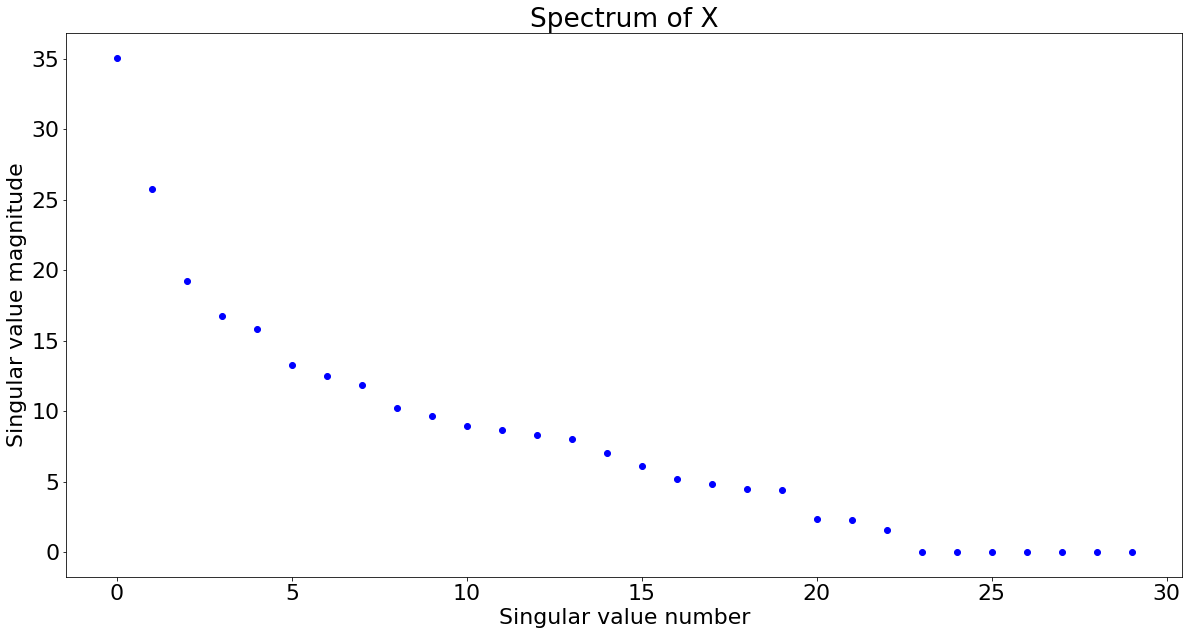

In [33]:
# Identify the most important principle components 
psa.plot_spectrum(heart_X.T)

In this case, the first two principle component directions seem to explain most of the variance within the dataset. I will therefore reduce to 2 dimensions for the predictions

In [34]:
#Get the first PCA direction and the first interpretable component direction
heart_pca2 = heart_comp[:2]
heart_interp2 = heart_all_interp[:2]

In [35]:
hrt_X_train, hrt_X_test, hrt_y_train, hrt_y_test = psa.train_test_split_w(heart_X, heart_Y)
hrt_y_predicted = psa.least_squares_classifier(hrt_X_train.values, hrt_X_test.values, hrt_y_train.values)
print("""Accuracy score on the test set for a LS classifier using 
         the original feature space is: {}""".format(accuracy_score(hrt_y_test.values, hrt_y_predicted)))

hrt_X_train_pca, hrt_X_test_pca, hrt_y_train_pca, hrt_y_test_pca = psa.train_test_split_w(heart_pca2.T, heart_Y)
hrt_y_predicted_pca = psa.least_squares_classifier(hrt_X_train_pca, hrt_X_test_pca, hrt_y_train_pca)
print("""Accuracy score on the test set for a LS classifier using 
         principal component vector space is {}""".format(accuracy_score(hrt_y_test_pca.values, hrt_y_predicted_pca)))

hrt_X_train_interp, hrt_X_test_interp, hrt_y_train_interp, hrt_y_test_interp = psa.train_test_split_w(heart_interp2.T, heart_Y)
hrt_y_predicted_interp = psa.least_squares_classifier(hrt_X_train_interp, hrt_X_test_interp, hrt_y_train_interp.values)
print("""Accuracy score on the test set for a LS classifier using 
         interpretable directions vector space is {}""".format(accuracy_score(hrt_y_test_interp.values, hrt_y_predicted_interp)))

Accuracy score on the test set for a LS classifier using 
         the original feature space is: 0.5901639344262295
Accuracy score on the test set for a LS classifier using 
         principal component vector space is 0.7704918032786885
Accuracy score on the test set for a LS classifier using 
         interpretable directions vector space is 0.7049180327868853


Unlike when using categorical data, the PCA and "interpretable directions" classifiers predicted with a a greater accuracy than the least squares classifier. In this case, while the least squares classifier had an accuracy of .59, classical PCA had an accuracy of .77 while the "interpretable directions" had an accuracy of .70. Using this dataset, the data was not made any more interpretable by Chipman and Gu's method, suggesting that any small gains in interpretability are not worth the loss in classification accuracy. 

## Repeat with another dataset, this time entirely categorical

Predict if mushrooms are poisonous or edible, based on different physical characteristics. 
For more info on dataset visit: https://www.kaggle.com/uciml/mushroom-classification

### Step 1: Load and preprocess data

In [68]:
shroom = pd.read_csv(data_directory + "mushrooms.csv")
shroom.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [76]:
shroom_cat = shroom.columns[1:]
mushroom = psa.dummy_cat_vars(shroom, shroom_cat)
mushroom = mushroom.dropna()
mushroom.head()

,class,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,p,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,1,0
1,e,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,e,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,p,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,e,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [77]:
#set all the poisonous to one and edible to -1
mushroom.loc[mushroom['class'] == "p", "class"] = 1
mushroom.loc[mushroom['class'] == "e", "class"] = -1
mushroom.head()

,class,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,1,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,1,0
1,-1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,-1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,-1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [78]:
#separate the X and Y matrices
mush_X = mushroom.iloc[:, 1:]
mush_Y = mushroom.loc[:,"class"]

We now have a collection of highly correlated categorical features that represent futher "clusters" of features, like cap shape, cap surface, population, habitat, and so forth. These may be interpretable. 

### Step 2: Run PCA and get components and correlations

In [79]:
mush_pca = PCA(n_components=len(mush_X.columns), svd_solver='full')
mush_pca.fit(mush_X.T)

mush_comp = mush_pca.components_

In [82]:
mush_corr = psa.corr_pc_features(mush_X, mush_comp)
mush_corr

C:\Users\passenh\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\passenh\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117
cap-shape_b,-0.192617,-0.187488,-0.060505,0.200336,0.350746,-0.183388,0.008798,-0.033565,-0.067576,0.027086,...,-1.847622e-15,-5.551682e-16,-2.619668e-17,-1.208742e-15,-3.159681e-15,2.892382e-15,-7.331712e-16,1.279943e-15,-4.871659e-15,1.903225e-15
cap-shape_c,-0.059426,-0.002024,-0.010807,0.009074,0.015459,-0.018213,-0.005795,0.016029,0.002242,-0.031094,...,-6.453968e-15,7.356527e-15,-3.459604e-15,-5.604825e-16,1.394881e-14,3.598135e-15,-2.812959e-15,-5.149561e-15,-7.455873e-15,3.103356e-15
cap-shape_f,0.080171,-0.012932,0.116633,-0.129435,-0.277451,-0.300447,0.800957,-0.181915,0.026915,-0.158558,...,7.294179e-16,-7.535896e-16,-4.619489e-16,1.122643e-15,9.289533e-16,-6.796525e-16,1.285486e-15,3.669997e-16,2.028728e-15,-1.841200e-15
cap-shape_k,-0.206573,0.366922,-0.266856,-0.036322,0.104146,-0.234040,-0.094434,0.017987,-0.118027,-0.007432,...,1.475862e-17,1.886558e-15,-1.139976e-15,-9.669438e-17,1.684518e-16,-2.698791e-15,-8.693588e-16,-1.117075e-15,1.494517e-15,1.409448e-15
cap-shape_s,0.008462,-0.028009,-0.026053,0.036948,0.015900,0.002481,-0.022789,-0.072082,0.103723,-0.166842,...,9.881758e-15,-1.169253e-14,3.329426e-15,2.317307e-15,-2.656475e-14,-5.417950e-15,6.059231e-15,1.120102e-14,3.036536e-15,-7.551585e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
habitat_l,-0.231250,0.360699,-0.265686,-0.084080,0.096112,-0.208107,-0.096569,-0.185724,0.268122,0.151853,...,-5.799443e-16,9.100352e-16,-2.793077e-17,-3.316144e-16,9.633576e-16,-1.448591e-16,-5.277646e-16,-6.308862e-16,3.308209e-16,1.024551e-16
habitat_m,-0.031096,-0.209847,-0.040902,0.101262,0.384910,0.072589,0.060227,0.034150,-0.036198,0.072946,...,-7.037643e-16,-4.211032e-16,3.029389e-16,-5.901881e-16,-8.449204e-16,1.452168e-15,-1.608071e-16,5.041400e-16,-1.545733e-15,6.124045e-16
habitat_p,-0.160974,0.398532,0.147562,-0.028852,0.121989,0.045590,0.096419,0.093195,0.023638,0.058643,...,-2.933690e-16,1.603736e-15,-1.227959e-16,-8.698153e-17,1.105639e-15,-9.174559e-16,-8.262692e-16,-9.874506e-16,-5.942078e-16,-1.675861e-16
habitat_u,0.064766,-0.127020,-0.056850,0.082017,0.143262,0.216683,0.147901,-0.262315,0.050135,-0.058260,...,1.616463e-15,-3.318222e-15,1.497387e-15,1.285670e-15,-7.054281e-15,-1.301981e-15,1.815409e-15,3.126356e-15,-8.008769e-16,-2.041923e-15


In [89]:
for idx, element in enumerate(mush_corr.loc[:, "PC1"]):
    print(mush_corr.index[idx], "\t\t", element)

cap-shape_b 		 -0.19261688916286468
cap-shape_c 		 -0.05942577027142393
cap-shape_f 		 0.08017088229042338
cap-shape_k 		 -0.20657261186255296
cap-shape_s 		 0.008462470968689682
cap-shape_x 		 0.1374293536077989
cap-surface_f 		 0.06082954975100258
cap-surface_g 		 -0.01843949202792391
cap-surface_s 		 -0.18928715752274
cap-surface_y 		 0.12420777093019426
cap-color_b 		 -0.019090607702747942
cap-color_c 		 -0.12050125335230169
cap-color_e 		 0.2236677523932918
cap-color_g 		 0.026198858913851715
cap-color_n 		 0.07232865480697437
cap-color_p 		 -0.039836402242512656
cap-color_r 		 -0.008919301259675329
cap-color_u 		 -0.008919301259675832
cap-color_w 		 -0.08978503849474025
cap-color_y 		 -0.2442356956927433
bruises_f 		 -0.5681299572449509
bruises_t 		 0.5681299572449509
odor_a 		 -0.012305888590687658
odor_c 		 0.061864253296756815
odor_f 		 -0.23335779148502606
odor_l 		 -0.012305888590688638
odor_m 		 -0.25092099257003125
odor_n 		 0.21368126254493372
odor_p 		 0.0271238099729906

There are lots of features, and not too many of them appear to be all that highly correlated with the first principle component direction. The features with correlation near 50% are habitat_d, which means the woods, ring_type_p, which is pendant, stalk_surface_above_ring_s and stalk_surface_below_ring_s, both of which are smooth, and both stalk shapes. While this is helpful insight into particulars, this does not tell us which PART of the mushroom (stalk, ring, etc) is most indicative of poison. We therefore apply Chipman and Gu's method to see if the "interpretable direction" is more interpretable.

### Run Chipman and Gu's algorithm to see the "interpretable" principle component directions. 

In [ ]:
#set up a matrix for the new interpretable directions
mush_interp = np.zeros(mush_comp.shape)

for i, row in enumerate(mush_comp):
    pcrow = psa.c_and_g_algo(row)
    mush_interp[i] = pcrow

In [ ]:
mush_interp_corr = psa.corr_pc_features(mush_X, mush_interp)
mush_interp_corr

In [ ]:
for idx, element in enumerate(mush_corr.loc[:, "PC1"]):
    print(mush_corr.index[idx], "\t\t", element)

In this case, we can again see some changes between the correlation of the original features and the principle components, and the correlation between the original features and the "interpretable directions. We can identify XX . 

### Step 3: Use the most important principle components to make a classification prediction

Finally, we will again compare least squares classification, normal PCA, and Chipman and Gu's "interpretable directions" and examine performance. For consistency and valid comparisons, we we use least squares classification on the original features, the reduced dimension PCA and and reduced dimension Interpretable Directions.

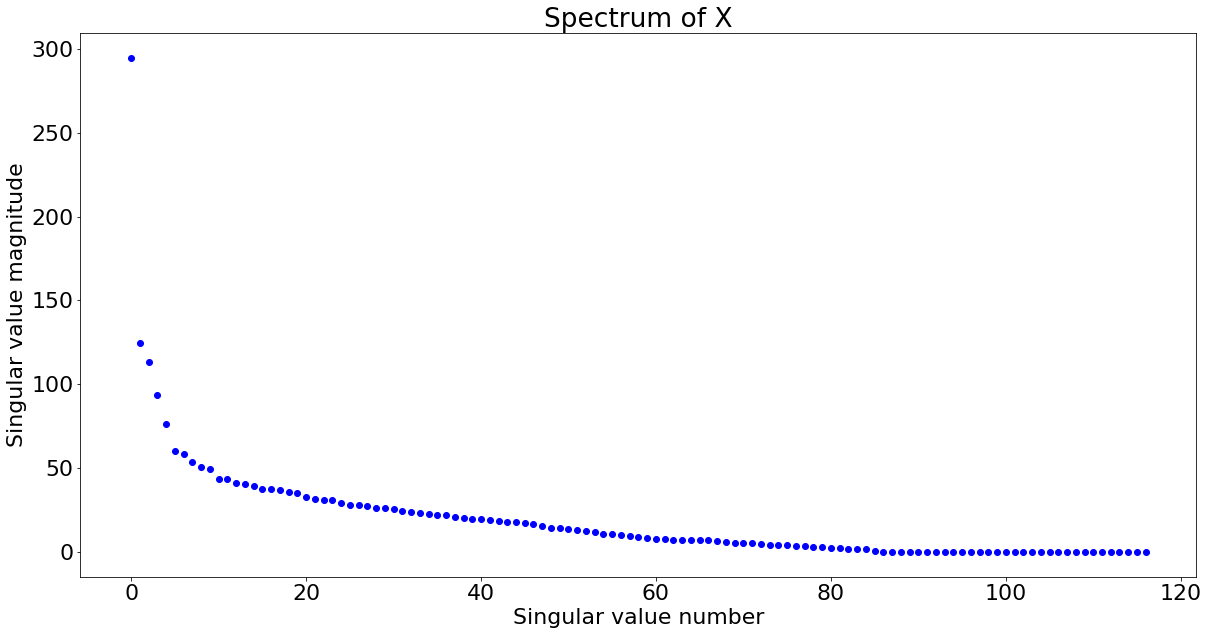

In [92]:
# Identify the most important principle components 
psa.plot_spectrum(mush_X.T)

In [ ]:
#Get the first PCA direction and the first interpretable component direction
mush_pca2 = mush_comp[:2]
mush_interp2 = mush_interp[:2]

In [ ]:
#Make predictions
mush_X_train, mush_X_test, mush_y_train, mush_y_test = psa.train_test_split_w(mush_X, mush_Y)
mush_y_predicted = psa.least_squares_classifier(mush_X_train.values, mush_X_test.values, mush_y_train.values)
print("""Accuracy score on the test set for a LS classifier using 
         the original feature space is: {}""".format(accuracy_score(mush_y_test.values, mush_y_predicted)))

mush_X_train_pca, mush_X_test_pca, mush_y_train_pca, mush_y_test_pca = psa.train_test_split_w(mush_pca2.T, mush_Y)
mush_y_predicted_pca = psa.least_squares_classifier(mush_X_train_pca, mush_X_test_pca, mush_y_train_pca)
print("""Accuracy score on the test set for a LS classifier using 
         principal component vector space is {}""".format(accuracy_score(hrt_y_test_pca.values, hrt_y_predicted_pca)))

mush_X_train_interp, mush_X_test_interp, mush_y_train_interp, mush_y_test_interp = psa.train_test_split_w(heart_interp2.T, mush_Y)
mush_y_predicted_interp = psa.least_squares_classifier(mush_X_train_interp, mush_X_test_interp, mush_y_train_interp.values)
print("""Accuracy score on the test set for a LS classifier using 
         interpretable directions vector space is {}""".format(accuracy_score(mush_y_test_interp.values, mush_y_predicted_interp)))